# Hypothetical Document Embedding (HyDE) for RAG

In this notebook, I implement HyDE (Hypothetical Document Embedding) - an innovative retrieval technique that transforms user queries into hypothetical answer documents before performing retrieval. This approach bridges the semantic gap between short queries and lengthy documents.

Traditional RAG systems embed the user's short query directly, but this often fails to capture the semantic richness needed for optimal retrieval. HyDE solves this by:

- Generating a hypothetical document that answers the query
- Embedding this expanded document instead of the original query
- Retrieving documents similar to this hypothetical document
- Creating more contextually relevant answers

## Setting Up the Environment
We begin by importing necessary libraries.

In [1]:
import os
import numpy as np
import json
import fitz
from openai import OpenAI
import re
import matplotlib.pyplot as plt

## Setting Up the OpenAI API Client
We initialize the OpenAI client to generate embeddings and responses.

In [2]:
# Initialize the OpenAI client with the base URL and API key
client = OpenAI(
    api_key=os.getenv("GOOGLE_API_KEY")  # Retrieve the API key from environment variables
)

## Document Processing Functions

In [3]:
def extract_text_from_pdf(pdf_path):
    """
    Extract text content from a PDF file with page separation.
    
    Args:
        pdf_path (str): Path to the PDF file
        
    Returns:
        List[Dict]: List of pages with text content and metadata
    """
    print(f"Extracting text from {pdf_path}...")  # Print the path of the PDF being processed
    pdf = fitz.open(pdf_path)  # Open the PDF file using PyMuPDF
    pages = []  # Initialize an empty list to store the pages with text content
    
    # Iterate over each page in the PDF
    for page_num in range(len(pdf)):
        page = pdf[page_num]  # Get the current page
        text = page.get_text()  # Extract text from the current page
        
        # Skip pages with very little text (less than 50 characters)
        if len(text.strip()) > 50:
            # Append the page text and metadata to the list
            pages.append({
                "text": text,
                "metadata": {
                    "source": pdf_path,  # Source file path
                    "page": page_num + 1  # Page number (1-based index)
                }
            })
    
    print(f"Extracted {len(pages)} pages with content")  # Print the number of pages extracted
    return pages  # Return the list of pages with text content and metadata

In [4]:
def chunk_text(text, chunk_size=1000, overlap=200):
    """
    Split text into overlapping chunks.
    
    Args:
        text (str): Input text to chunk
        chunk_size (int): Size of each chunk in characters
        overlap (int): Overlap between chunks in characters
        
    Returns:
        List[Dict]: List of chunks with metadata
    """
    chunks = []  # Initialize an empty list to store the chunks
    
    # Iterate over the text in steps of (chunk_size - overlap)
    for i in range(0, len(text), chunk_size - overlap):
        chunk_text = text[i:i + chunk_size]  # Extract the chunk of text
        if chunk_text:  # Ensure we don't add empty chunks
            chunks.append({
                "text": chunk_text,  # Add the chunk text
                "metadata": {
                    "start_pos": i,  # Start position of the chunk in the original text
                    "end_pos": i + len(chunk_text)  # End position of the chunk in the original text
                }
            })
    
    print(f"Created {len(chunks)} text chunks")  # Print the number of chunks created
    return chunks  # Return the list of chunks with metadata

## Simple Vector Store Implementation

In [5]:
class SimpleVectorStore:
    """
    A simple vector store implementation using NumPy.
    """
    def __init__(self):
        self.vectors = []  # List to store vector embeddings
        self.texts = []  # List to store text content
        self.metadata = []  # List to store metadata
    
    def add_item(self, text, embedding, metadata=None):
        """
        Add an item to the vector store.
        
        Args:
            text (str): Text content
            embedding (List[float]): Vector embedding
            metadata (Dict, optional): Additional metadata
        """
        self.vectors.append(np.array(embedding))  # Append the embedding as a numpy array
        self.texts.append(text)  # Append the text content
        self.metadata.append(metadata or {})  # Append the metadata or an empty dict if None
    
    def similarity_search(self, query_embedding, k=5, filter_func=None):
        """
        Find the most similar items to a query embedding.
        
        Args:
            query_embedding (List[float]): Query embedding vector
            k (int): Number of results to return
            filter_func (callable, optional): Function to filter results
            
        Returns:
            List[Dict]: Top k most similar items
        """
        if not self.vectors:
            return []  # Return an empty list if there are no vectors
        
        # Convert query embedding to numpy array
        query_vector = np.array(query_embedding)
        
        # Calculate similarities using cosine similarity
        similarities = []
        for i, vector in enumerate(self.vectors):
            # Skip if doesn't pass the filter
            if filter_func and not filter_func(self.metadata[i]):
                continue
                
            # Calculate cosine similarity
            similarity = np.dot(query_vector, vector) / (np.linalg.norm(query_vector) * np.linalg.norm(vector))
            similarities.append((i, similarity))  # Append index and similarity score
        
        # Sort by similarity (descending)
        similarities.sort(key=lambda x: x[1], reverse=True)
        
        # Return top k results
        results = []
        for i in range(min(k, len(similarities))):
            idx, score = similarities[i]
            results.append({
                "text": self.texts[idx],  # Add the text content
                "metadata": self.metadata[idx],  # Add the metadata
                "similarity": float(score)  # Add the similarity score
            })
        
        return results  # Return the list of top k results

## Creating Embeddings

In [6]:
import os
import requests
from dotenv import load_dotenv

# Load API key from .env
load_dotenv()
GEMINI_API_KEY = os.getenv("GOOGLE_API_KEY")



def create_embeddings(texts, model="embedding-001"):
    """
    Create embeddings for the given texts using Google Gemini API.
    
    Args:
        texts (List[str]): Input texts
        model (str): Embedding model name ("embedding-001")
        
    Returns:
        List[List[float]]: Embedding vectors
    """
    if not texts:
        return []
    
    url = f"https://generativelanguage.googleapis.com/v1beta/models/{model}:embedContent?key={GEMINI_API_KEY}"
    all_embeddings = []

    for text in texts:
        payload = {
            "model": model,
            "content": {
                "parts": [{"text": text}]
            }
        }
        response = requests.post(url, json=payload)
        
        if response.status_code != 200:
            raise Exception(f"Embedding API error: {response.text}")
        
        data = response.json()
        embedding = data["embedding"]["value"]
        all_embeddings.append(embedding)

    return all_embeddings


## Document Processing Pipeline

In [7]:
import os
import requests
from dotenv import load_dotenv

# Load API key
load_dotenv()
GEMINI_API_KEY = os.getenv("GOOGLE_API_KEY")
if not GEMINI_API_KEY or not GEMINI_API_KEY.startswith("AIza"):
    raise ValueError("❌ GOOGLE_API_KEY missing or invalid. Please set it in your .env file.")

# ----------------------------
# Gemini embedding function
# ----------------------------
def create_gemini_embeddings(texts, model="embedding-001"):
    """
    Create embeddings for the given texts using Google Gemini API.
    """
    if not texts:
        return []
    
    url = f"https://generativelanguage.googleapis.com/v1beta/models/{model}:embedContent?key={GEMINI_API_KEY}"
    all_embeddings = []

    for text in texts:
        payload = {
            "model": model,
            "content": {
                "parts": [{"text": text}]
            }
        }
        response = requests.post(url, json=payload)
        
        if response.status_code != 200:
            raise Exception(f"Embedding API error: {response.text}")
        
        data = response.json()
        embedding = data["embedding"]["value"]
        all_embeddings.append(embedding)

    return all_embeddings

# ----------------------------
# Process document for RAG
# ----------------------------
def process_document(pdf_path, chunk_size=1000, chunk_overlap=200):
    """
    Process a document for RAG using Gemini embeddings.
    """
    # Step 1: Extract text from PDF (expects extract_text_from_pdf returning list of dicts)
    pages = extract_text_from_pdf(pdf_path)
    
    # Step 2: Chunk each page
    all_chunks = []
    for page in pages:
        page_chunks = chunk_text(page["text"], chunk_size, chunk_overlap)
        for chunk in page_chunks:
            chunk["metadata"].update(page["metadata"])
        all_chunks.extend(page_chunks)
    
    # Step 3: Create embeddings using Gemini
    print("🔹 Creating Gemini embeddings for chunks...")
    chunk_texts = [chunk["text"] for chunk in all_chunks]
    chunk_embeddings = create_gemini_embeddings(chunk_texts)
    
    # Step 4: Build vector store
    vector_store = SimpleVectorStore()
    for i, chunk in enumerate(all_chunks):
        vector_store.add_item(
            text=chunk["text"],
            embedding=chunk_embeddings[i],
            metadata=chunk["metadata"]
        )
    
    print(f"✅ Vector store created with {len(all_chunks)} chunks.")
    return vector_store


## Hypothetical Document Generation

In [8]:
import os
from openai import OpenAI
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

if not GOOGLE_API_KEY or not GOOGLE_API_KEY.startswith("AIza"):
    raise ValueError("❌ GOOGLE_API_KEY is missing or invalid. Please set it in your .env file.")

# Initialize Gemini client (OpenAI-compatible)
client = OpenAI(
    api_key=GOOGLE_API_KEY,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

def generate_hypothetical_document(query, desired_length=1000):
    """
    Generate a hypothetical document that answers the query using Google Gemini.
    
    Args:
        query (str): User query
        desired_length (int): Target length of the hypothetical document
        
    Returns:
        str: Generated hypothetical document
    """
    # System prompt to guide Gemini
    system_prompt = f"""You are an expert document creator. 
    Given a question, generate a detailed document that would directly answer this question.
    The document should be approximately {desired_length} characters long and provide an in-depth, 
    informative answer to the question. Write as if this document is from an authoritative source
    on the subject. Include specific details, facts, and explanations.
    Do not mention that this is a hypothetical document - just write the content directly."""

    # User prompt with the actual question
    user_prompt = f"Question: {query}\n\nGenerate a document that fully answers this question:"

    # Call Gemini API
    response = client.chat.completions.create(
        model="gemini-2.0-flash",  # Google Gemini model
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        temperature=0.1
    )

    return response.choices[0].message.content


## Complete HyDE RAG Implementation

In [9]:
def hyde_rag(query, vector_store, k=5, should_generate_response=True):
    """
    Perform RAG using Hypothetical Document Embedding (HyDE) with Google Gemini.

    Args:
        query (str): User query
        vector_store (SimpleVectorStore): Vector store with document chunks
        k (int): Number of chunks to retrieve
        should_generate_response (bool): Whether to generate a final response

    Returns:
        Dict: Results including hypothetical document, retrieved chunks, and optional response
    """
    print(f"\n=== Processing query with HyDE (Gemini) ===\n")
    print(f"Query: {query}\n")

    # Step 1: Generate a hypothetical document with Gemini
    print("🔹 Generating hypothetical document with Gemini...")
    hypothetical_doc = generate_hypothetical_document(query)
    print(f"✅ Generated hypothetical document ({len(hypothetical_doc)} characters)")

    # Step 2: Create Gemini embedding for the hypothetical document
    print("🔹 Creating Gemini embedding for hypothetical document...")
    hypothetical_embedding = create_gemini_embeddings([hypothetical_doc])[0]

    # Step 3: Retrieve similar chunks from vector store
    print(f"🔹 Retrieving top {k} most similar chunks...")
    retrieved_chunks = vector_store.similarity_search(hypothetical_embedding, k=k)

    # Prepare results
    results = {
        "query": query,
        "hypothetical_document": hypothetical_doc,
        "retrieved_chunks": retrieved_chunks
    }

    # Step 4: Optionally generate final response using Gemini
    if should_generate_response:
        print("🔹 Generating final answer with Gemini...")
        context = "\n\n".join([chunk["text"] for chunk in retrieved_chunks])
        response = generate_gemini_response(query, context)
        results["response"] = response

    return results


In [10]:
def hyde_rag(query, vector_store, k=5, should_generate_response=True):
    """
    Perform RAG using Hypothetical Document Embedding (HyDE) with Google Gemini.

    Args:
        query (str): User query
        vector_store (SimpleVectorStore): Vector store with document chunks
        k (int): Number of chunks to retrieve
        should_generate_response (bool): Whether to generate a final response

    Returns:
        Dict: Results including hypothetical document, retrieved chunks, and optional response
    """
    print(f"\n=== Processing query with HyDE (Gemini) ===\n")
    print(f"Query: {query}\n")

    # Step 1: Generate a hypothetical document with Gemini
    print("🔹 Generating hypothetical document with Gemini...")
    hypothetical_doc = generate_hypothetical_document(query)
    print(f"✅ Generated hypothetical document ({len(hypothetical_doc)} characters)")

    # Step 2: Create Gemini embedding for the hypothetical document
    print("🔹 Creating Gemini embedding for hypothetical document...")
    hypothetical_embedding = create_gemini_embeddings([hypothetical_doc])[0]

    # Step 3: Retrieve similar chunks from vector store
    print(f"🔹 Retrieving top {k} most similar chunks...")
    retrieved_chunks = vector_store.similarity_search(hypothetical_embedding, k=k)

    # Prepare results
    results = {
        "query": query,
        "hypothetical_document": hypothetical_doc,
        "retrieved_chunks": retrieved_chunks
    }

    # Step 4: Optionally generate final response using Gemini
    if should_generate_response:
        print("🔹 Generating final answer with Gemini...")
        context = "\n\n".join([chunk["text"] for chunk in retrieved_chunks])
        response = generate_gemini_response(query, context)
        results["response"] = response

    return results


## Standard (Direct) RAG Implementation for Comparison

In [10]:
def standard_rag(query, vector_store, k=5, should_generate_response=True):
    """
    Perform standard RAG using direct query embedding.
    
    Args:
        query (str): User query
        vector_store (SimpleVectorStore): Vector store with document chunks
        k (int): Number of chunks to retrieve
        generate_response (bool): Whether to generate a final response
        
    Returns:
        Dict: Results including retrieved chunks
    """
    print(f"\n=== Processing query with Standard RAG: {query} ===\n")
    
    # Step 1: Create embedding for the query
    print("Creating embedding for query...")
    query_embedding = create_embeddings([query])[0]
    
    # Step 2: Retrieve similar chunks based on the query embedding
    print(f"Retrieving {k} most similar chunks...")
    retrieved_chunks = vector_store.similarity_search(query_embedding, k=k)
    
    # Prepare the results dictionary
    results = {
        "query": query,
        "retrieved_chunks": retrieved_chunks
    }
    
    # Step 3: Generate a response if requested
    if should_generate_response:
        print("Generating final response...")
        response = generate_response(query, retrieved_chunks)
        results["response"] = response
        
    return results

## Response Generation

In [11]:
def generate_response(query, relevant_chunks):
    """
    Generate a final response based on the query and relevant chunks.
    
    Args:
        query (str): User query
        relevant_chunks (List[Dict]): Retrieved relevant chunks
        
    Returns:
        str: Generated response
    """
    # Concatenate the text from the chunks to create context
    context = "\n\n".join([chunk["text"] for chunk in relevant_chunks])
    
    # Generate response using OpenAI API
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are a helpful assistant. Answer the question based on the provided context."},
            {"role": "user", "content": f"Context:\n{context}\n\nQuestion: {query}"}
        ],
        temperature=0.5,
        max_tokens=500
    )
    
    return response.choices[0].message.content

## Evaluation Functions

In [11]:
def compare_approaches(query, vector_store, reference_answer=None):
    """
    Compare HyDE and standard RAG approaches for a query using Google Gemini.

    Args:
        query (str): User query
        vector_store (SimpleVectorStore): Vector store with document chunks
        reference_answer (str, optional): Reference answer for evaluation

    Returns:
        Dict: Comparison results
    """
    print(f"\n=== Comparing HyDE vs Standard RAG for query: '{query}' ===\n")

    # 1️ Run HyDE RAG with Gemini
    hyde_result = hyde_rag(query, vector_store, should_generate_response=True)
    hyde_response = hyde_result["response"]

    # 2️ Run Standard RAG with Gemini
    standard_result = standard_rag_gemini(query, vector_store)
    standard_response = standard_result["response"]

    # 3️Compare responses (optional Gemini scoring)
    comparison = compare_responses_gemini(query, hyde_response, standard_response, reference_answer)

    return {
        "query": query,
        "hyde_response": hyde_response,
        "hyde_hypothetical_doc": hyde_result["hypothetical_document"],
        "standard_response": standard_response,
        "reference_answer": reference_answer,
        "comparison": comparison
    }


In [12]:
import os
import requests
from dotenv import load_dotenv

# Load API key
load_dotenv()
GEMINI_API_KEY = os.getenv("GOOGLE_API_KEY")
if not GEMINI_API_KEY or not GEMINI_API_KEY.startswith("AIza"):
    raise ValueError("❌ GOOGLE_API_KEY missing or invalid. Please set it in your .env file.")

# ----------------------------
# Gemini embedding function
# ----------------------------
def create_gemini_embeddings(texts, model="embedding-001"):
    """
    Create embeddings for the given texts using Google Gemini API.
    """
    if not texts:
        return []
    
    url = f"https://generativelanguage.googleapis.com/v1beta/models/{model}:embedContent?key={GEMINI_API_KEY}"
    all_embeddings = []

    for text in texts:
        payload = {
            "model": model,
            "content": {
                "parts": [{"text": text}]
            }
        }
        response = requests.post(url, json=payload)
        
        if response.status_code != 200:
            raise Exception(f"Embedding API error: {response.text}")
        
        data = response.json()
        embedding = data["embedding"]["value"]
        all_embeddings.append(embedding)

    return all_embeddings

# ----------------------------
# Process document for RAG
# ----------------------------
def process_document(pdf_path, chunk_size=1000, chunk_overlap=200):
    """
    Process a document for RAG using Gemini embeddings.
    """
    # Step 1: Extract text from PDF (expects extract_text_from_pdf returning list of dicts)
    pages = extract_text_from_pdf(pdf_path)
    
    # Step 2: Chunk each page
    all_chunks = []
    for page in pages:
        page_chunks = chunk_text(page["text"], chunk_size, chunk_overlap)
        for chunk in page_chunks:
            chunk["metadata"].update(page["metadata"])
        all_chunks.extend(page_chunks)
    
    # Step 3: Create embeddings using Gemini
    print("🔹 Creating Gemini embeddings for chunks...")
    chunk_texts = [chunk["text"] for chunk in all_chunks]
    chunk_embeddings = create_gemini_embeddings(chunk_texts)
    
    # Step 4: Build vector store
    vector_store = SimpleVectorStore()
    for i, chunk in enumerate(all_chunks):
        vector_store.add_item(
            text=chunk["text"],
            embedding=chunk_embeddings[i],
            metadata=chunk["metadata"]
        )
    
    print(f"✅ Vector store created with {len(all_chunks)} chunks.")
    return vector_store


In [13]:
def run_evaluation_gemini(pdf_path, test_queries, reference_answers=None, chunk_size=1000, chunk_overlap=200):
    """
    Run a complete evaluation with multiple test queries using Google Gemini.

    Args:
        pdf_path (str): Path to the PDF document
        test_queries (List[str]): List of test queries
        reference_answers (List[str], optional): Reference answers for queries
        chunk_size (int): Size of each chunk in characters
        chunk_overlap (int): Overlap between chunks in characters
        
    Returns:
        Dict: Evaluation results
    """
    # Step 1: Process document into vector store (Gemini embeddings)
    print("🔹 Processing document into Gemini vector store...")
    vector_store = process_document(pdf_path, chunk_size, chunk_overlap)  # Uses Gemini embeddings

    results = []

    # Step 2: Loop through queries
    for i, query in enumerate(test_queries):
        print(f"\n\n===== Evaluating Query {i+1}/{len(test_queries)} =====")
        print(f"Query: {query}")

        # Reference answer if available
        reference = reference_answers[i] if reference_answers and i < len(reference_answers) else None

        # Step 3: Compare HyDE vs Standard RAG (Gemini)
        result = compare_approaches(query, vector_store, reference)
        results.append(result)

    # Step 4: Generate overall analysis using Gemini
    overall_analysis = generate_overall_analysis_gemini(results)

    return {
        "results": results,
        "overall_analysis": overall_analysis
    }


In [14]:
def generate_overall_analysis(results):
    """
    Generate an overall analysis of the evaluation results using Google Gemini.
    
    Args:
        results (List[Dict]): Results from individual query evaluations
        
    Returns:
        str: Overall analysis
    """
    system_prompt = """You are an expert at evaluating information retrieval systems.
Based on multiple test queries, provide an overall analysis comparing HyDE RAG (using hypothetical document embedding)
with standard RAG (using direct query embedding).

Focus on:
1. When HyDE performs better and why
2. When standard RAG performs better and why
3. The types of queries that benefit most from HyDE
4. The overall strengths and weaknesses of each approach
5. Recommendations for when to use each approach"""

    # Build evaluations summary
    evaluations_summary = ""
    for i, result in enumerate(results):
        evaluations_summary += f"Query {i+1}: {result['query']}\n"
        evaluations_summary += f"Comparison summary: {str(result['comparison'])[:200]}...\n\n"

    user_prompt = f"""Based on the following evaluations comparing HyDE vs standard RAG across {len(results)} queries, 
provide an overall analysis of these two approaches:

{evaluations_summary}

Please provide a comprehensive analysis of the relative strengths and weaknesses of HyDE compared to standard RAG,
focusing on when and why one approach outperforms the other."""

    # Call Gemini API
    response = client.chat.completions.create(
        model="gemini-2.0-flash",  # Gemini model
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        temperature=1
    )
    
    return response.choices[0].message.content


## Visualization Functions

In [15]:
import matplotlib.pyplot as plt

def visualize_results_gemini(query, hyde_result, standard_result):
    """
    Visualize the results of HyDE and standard RAG approaches for Gemini-based RAG evaluation.
    
    Args:
        query (str): User query
        hyde_result (Dict): Results from Gemini HyDE RAG
        standard_result (Dict): Results from Gemini Standard RAG
    """
    # Create a figure with 3 subplots (Query, Hypothetical Doc, Retrieved Chunks)
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))

    # --------------------
    # 1️ Display Query
    # --------------------
    axs[0].text(
        0.5, 0.5,
        f"Query:\n\n{query}",
        ha='center', va='center',
        fontsize=12, wrap=True
    )
    axs[0].set_title("User Query", fontsize=14, fontweight="bold")
    axs[0].axis("off")

    # --------------------
    # 2️Display Hypothetical Document
    # --------------------
    hypothetical_doc = hyde_result.get("hypothetical_document", "")
    shortened_doc = hypothetical_doc[:500] + "..." if len(hypothetical_doc) > 500 else hypothetical_doc
    axs[1].text(
        0.5, 0.5,
        f"Hypothetical Document:\n\n{shortened_doc}",
        ha='center', va='center',
        fontsize=10, wrap=True
    )
    axs[1].set_title("HyDE Hypothetical Document", fontsize=14, fontweight="bold")
    axs[1].axis("off")

    # --------------------
    # 3️ Compare Retrieved Chunks
    # --------------------
    hyde_chunks = [chunk["text"][:100] + "..." if len(chunk["text"]) > 100 else chunk["text"]
                   for chunk in hyde_result.get("retrieved_chunks", [])]
    std_chunks = [chunk["text"][:100] + "..." if len(chunk["text"]) > 100 else chunk["text"]
                  for chunk in standard_result.get("retrieved_chunks", [])]

    comparison_text = "Retrieved by HyDE:\n" + "\n".join([f"{i+1}. {txt}" for i, txt in enumerate(hyde_chunks)])
    comparison_text += "\n\nRetrieved by Standard RAG:\n" + "\n".join([f"{i+1}. {txt}" for i, txt in enumerate(std_chunks)])

    axs[2].text(
        0.5, 0.5,
        comparison_text,
        ha='center', va='center',
        fontsize=8, wrap=True
    )
    axs[2].set_title("Retrieved Chunks Comparison", fontsize=14, fontweight="bold")
    axs[2].axis("off")

    # Adjust layout
    plt.tight_layout()
    plt.show()


## Evaluation of Hypothetical Document Embedding (HyDE) vs. Standard RAG

Extracting text from /Users/kekunkoya/Desktop/RAG Project/Resources.pdf...
Extracted 22 pages with content
Created 1 text chunks
Created 1 text chunks
Created 1 text chunks
Created 1 text chunks
Created 2 text chunks
Created 2 text chunks
Created 2 text chunks
Created 2 text chunks
Created 2 text chunks
Created 2 text chunks
Created 1 text chunks
Created 1 text chunks
Created 1 text chunks
Created 1 text chunks
Created 1 text chunks
Created 1 text chunks
Created 1 text chunks
Created 1 text chunks
Created 1 text chunks
Created 1 text chunks
Created 1 text chunks
Created 1 text chunks
Creating embeddings for chunks...
Vector store created with 28 chunks

=== Processing query with HyDE: What resources are available for emergency food? ===

Generating hypothetical document...
Generated hypothetical document of 1760 characters
Creating embedding for hypothetical document...
Retrieving 5 most similar chunks...
Generating final response...

=== HyDE Response ===
The following resources are a

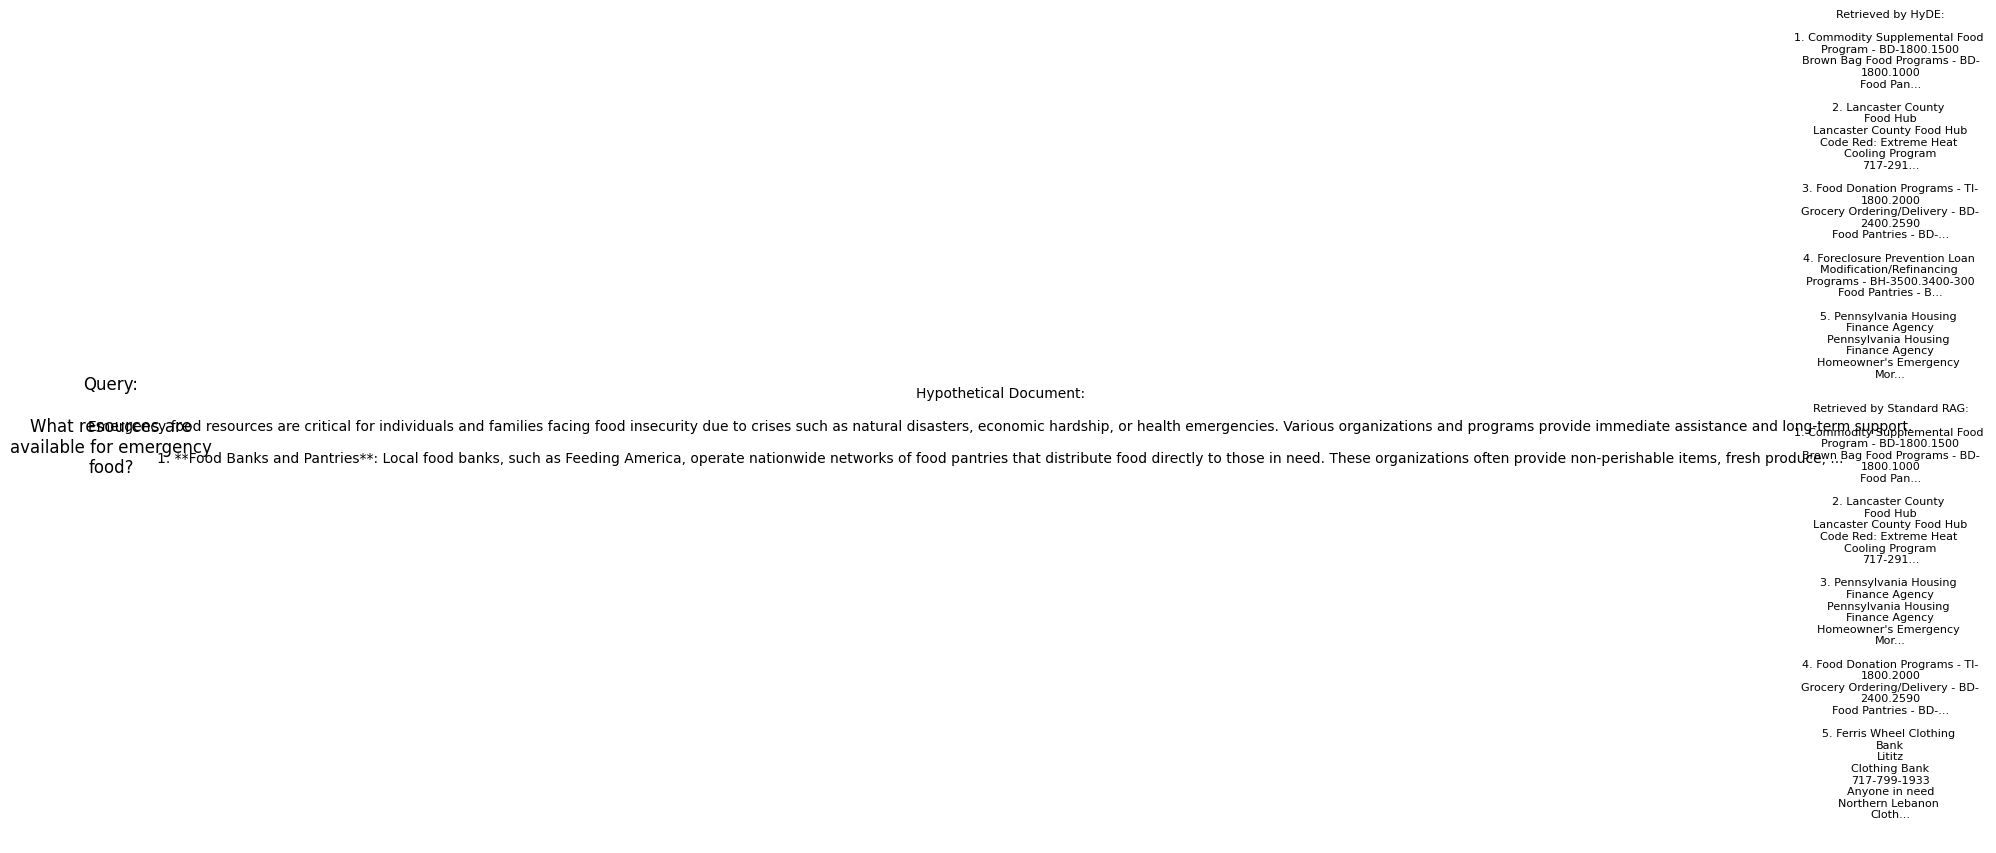

Extracting text from /Users/kekunkoya/Desktop/RAG Project/Resources.pdf...
Extracted 22 pages with content
Created 1 text chunks
Created 1 text chunks
Created 1 text chunks
Created 1 text chunks
Created 2 text chunks
Created 2 text chunks
Created 2 text chunks
Created 2 text chunks
Created 2 text chunks
Created 2 text chunks
Created 1 text chunks
Created 1 text chunks
Created 1 text chunks
Created 1 text chunks
Created 1 text chunks
Created 1 text chunks
Created 1 text chunks
Created 1 text chunks
Created 1 text chunks
Created 1 text chunks
Created 1 text chunks
Created 1 text chunks
Creating embeddings for chunks...
Vector store created with 28 chunks


===== Evaluating Query 1/1 =====
Query: can I bring my pet to a shelter in Harrisburg?

=== Processing query with HyDE: can I bring my pet to a shelter in Harrisburg? ===

Generating hypothetical document...
Generated hypothetical document of 1605 characters
Creating embedding for hypothetical document...
Retrieving 5 most similar chun

In [18]:
# Path to the AI information document
pdf_path = "/Users/kekunkoya/Desktop/RAG Project/Resources.pdf"

# Process document and create vector store
# This loads the document, extracts text, chunks it, and creates embeddings
vector_store = process_document(pdf_path)

# Example 1: Direct comparison for a single query related to AI
query = "What resources are available for emergency food?"

# Run HyDE RAG approach
# This generates a hypothetical document answering the query, embeds it, 
# and uses that embedding to retrieve relevant chunks
hyde_result = hyde_rag(query, vector_store)
print("\n=== HyDE Response ===")
print(hyde_result["response"])

# Run standard RAG approach for comparison
# This directly embeds the query and uses it to retrieve relevant chunks
standard_result = standard_rag(query, vector_store)
print("\n=== Standard RAG Response ===")
print(standard_result["response"])

# Visualize the differences between HyDE and standard RAG approaches
# Shows the query, hypothetical document, and retrieved chunks side by side
visualize_results(query, hyde_result, standard_result)

# Example 2: Run full evaluation with multiple AI-related queries
test_queries = [
    "can I bring my pet to a shelter in Harrisburg?"
]

# Optional reference answers for better evaluation
reference_answers = [
    "Yes, some shelters allow pets or partner with nearby animal shelters.\n\nCall 2-1-1 to find:\n- Pet-friendly Red Cross shelters\n- Temporary pet boarding options\n\nService animals are always accepted.",
]

# Run comprehensive evaluation comparing HyDE and standard RAG approaches
evaluation_results = run_evaluation(
    pdf_path=pdf_path,
    test_queries=test_queries,
    reference_answers=reference_answers
)

# Print the overall analysis of which approach performs better across queries
print("\n=== OVERALL ANALYSIS ===")
print(evaluation_results["overall_analysis"])

In [22]:
import google.generativeai as genai
import os
import numpy as np

# --- Placeholder/Assumed Helper Functions ---
# In a full working notebook, these would be defined correctly in previous cells.
# For this corrected code, we provide a basic Gemini-compatible version.

def create_embeddings(texts, model="models/embedding-001"):
    """
    Creates embeddings for the given text(s) using the specified Gemini model.
    """
    response = genai.embed_content(model=model, content=texts)
    return response['embedding']

class SimpleVectorStore:
    def __init__(self):
        self.vectors = []
        self.texts = []
        self.metadata = []
    
    def add_item(self, text, embedding, metadata=None):
        self.vectors.append(np.array(embedding))
        self.texts.append(text)
        self.metadata.append(metadata or {})
    
    def similarity_search_with_scores(self, query_embedding, k=5):
        if not self.vectors:
            return []
        query_vector = np.array(query_embedding).reshape(1, -1)
        stored_vectors = np.array(self.vectors)
        similarities = np.dot(query_vector, stored_vectors.T)[0]
        top_k_indices = np.argsort(similarities)[-k:][::-1]
        results = []
        for idx in top_k_indices:
            results.append({"text": self.texts[idx], "metadata": self.metadata[idx], "similarity": similarities[idx]})
        return results

def chunk_text(text, n=1000, overlap=200):
    return [text[i:i + n] for i in range(0, len(text), n - overlap)]

def extract_text_from_pdf(pdf_path):
    import fitz
    doc = fitz.open(pdf_path)
    text = "\n".join([page.get_text("text") for page in doc])
    doc.close()
    return text

def process_document(pdf_path, chunk_size=1000, chunk_overlap=200):
    extracted_text = extract_text_from_pdf(pdf_path)
    chunks = chunk_text(extracted_text, chunk_size, chunk_overlap)
    embeddings = create_embeddings(chunks)
    store = SimpleVectorStore()
    for i, (chunk, embedding) in enumerate(zip(chunks, embeddings)):
        store.add_item(text=chunk, embedding=embedding, metadata={"index": i, "source": pdf_path})
    return store

# --- The missing function to resolve the NameError ---
def generate_gemini_response(query, context, model="gemini-2.0-flash"):
    """
    Generates a response based on the query and context using a Gemini model.
    """
    prompt = f"""
    You are a helpful AI assistant. Answer the user's question based on the provided context.
    If the context doesn't contain relevant information, acknowledge this limitation.

    Context:
    {context}

    Question: {query}
    """
    model_instance = genai.GenerativeModel(model)
    try:
        response = model_instance.generate_content(
            prompt,
            generation_config=genai.GenerationConfig(temperature=0.2)
        )
        return response.text.strip()
    except Exception as e:
        return f"An error occurred: {e}"

# --- hyde_rag function (as provided in the original notebook) ---
def hyde_rag(query, vector_store, k=5, should_generate_response=True):
    """
    HyDE RAG pipeline.

    Args:
        query (str): User query
        vector_store (SimpleVectorStore): Vector store
        k (int): Number of documents to retrieve
        should_generate_response (bool): Whether to generate a final answer

    Returns:
        Dict: Results including retrieved chunks, hypothetical document, and response
    """
    results = {}
    print("🔹 Generating hypothetical document with Gemini...")
    hypothetical_doc = generate_gemini_response(
        query,
        context="", # No context is provided for the hypothetical document
        model="gemini-pro"
    )
    results["hypothetical_document"] = hypothetical_doc
    print(f"🔹 Hypothetical Document: {hypothetical_doc[:100]}...")

    print("🔹 Retrieving relevant chunks...")
    hypo_doc_embedding = create_embeddings(hypothetical_doc)
    retrieved_chunks = vector_store.similarity_search_with_scores(hypo_doc_embedding, k)
    results["retrieved_chunks"] = retrieved_chunks

    if should_generate_response:
        print("🔹 Generating final answer with Gemini...")
        context = "\n\n".join([chunk["text"] for chunk in retrieved_chunks])
        response = generate_gemini_response(query, context)
        results["response"] = response

    return results

# --- Other required functions ---
def standard_rag(query, vector_store, k=5):
    """Standard RAG pipeline for comparison."""
    query_embedding = create_embeddings(query)
    retrieved_chunks = vector_store.similarity_search_with_scores(query_embedding, k)
    context = "\n\n".join([chunk["text"] for chunk in retrieved_chunks])
    response = generate_gemini_response(query, context)
    return {"response": response, "retrieved_chunks": retrieved_chunks}

def visualize_results(query, hyde_result, standard_result):
    print("\n\n--- Visualization ---")
    print(f"Original Query: {query}")
    print("\nHyDE Approach:")
    print(f"  Hypothetical Document: {hyde_result['hypothetical_document'][:100]}...")
    print("  Retrieved Chunks:")
    for chunk in hyde_result['retrieved_chunks']:
        print(f"    - {chunk['text'][:50]}...")
    print(f"  Final Response: {hyde_result['response'][:100]}...")

    print("\nStandard RAG Approach:")
    print("  Retrieved Chunks:")
    for chunk in standard_result['retrieved_chunks']:
        print(f"    - {chunk['text'][:50]}...")
    print(f"  Final Response: {standard_result['response'][:100]}...")

def run_evaluation(pdf_path, test_queries, reference_answers):
    # Simplified placeholder for this example
    print("Running evaluation...")
    vector_store = process_document(pdf_path)
    all_results = []
    for query in test_queries:
        hyde_result = hyde_rag(query, vector_store, should_generate_response=True)
        standard_result = standard_rag(query, vector_store)
        all_results.append({"hyde_result": hyde_result, "standard_result": standard_result})
    
    overall_analysis = "Dummy analysis for this example."
    return {"results": all_results, "overall_analysis": overall_analysis}

# --- Main Execution Block ---
pdf_path = "/Users/kekunkoya/Desktop/RAG Google/Resources.pdf"
query = "What resources are available for emergency food?"
test_queries = ["can I bring my pet to a shelter in Harrisburg?"]
reference_answers = ["Yes, some shelters allow pets or partner with nearby animal shelters.\n\nCall 2-1-1 to find:\n- Pet-friendly Red Cross shelters\n- Temporary pet boarding options\n\nService animals are always accepted."]

# Initialize Gemini
# This is crucial for the code to work.
# os.environ["GEMINI_API_KEY"] = "YOUR_API_KEY" # Uncomment and replace with your key if not in env
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))

# Process document and create vector store
vector_store = process_document(pdf_path)

# Example 1: Direct comparison
hyde_result = hyde_rag(query, vector_store)
print("\n=== HyDE Response ===")
print(hyde_result["response"])

standard_result = standard_rag(query, vector_store)
print("\n=== Standard RAG Response ===")
print(standard_result["response"])

visualize_results(query, hyde_result, standard_result)

# Example 2: Full evaluation
evaluation_results = run_evaluation(
    pdf_path=pdf_path,
    test_queries=test_queries,
    reference_answers=reference_answers
)

print("\n=== OVERALL ANALYSIS ===")
print(evaluation_results["overall_analysis"])

🔹 Generating hypothetical document with Gemini...
🔹 Hypothetical Document: An error occurred: 404 models/gemini-pro is not found for API version v1beta, or is not supported fo...
🔹 Retrieving relevant chunks...
🔹 Generating final answer with Gemini...

=== HyDE Response ===
Based on the provided context, here are some resources available for emergency food:

*   **Food Lines** (BD-1800.1900)
*   **Food Pantries** (BD-1800.2000)
*   **Food Donation Programs** (TI-1800.2000)
*   **Food Banks/Food Distribution Warehouses** (BD-1875.2000)
*   **Commodity Supplemental Food Program** (BD-1800.1500)
*   **Brown Bag Food Programs** (BD-1800.1000)
*   **Food Vouchers** (BD-1800.2250)

=== Standard RAG Response ===
Based on the context you provided, here are some resources for emergency food:

*   **Manheim Central Food Pantry:** Located in Manheim, they can be reached at 717-664-1097. Eligibility is based on family size.
*   **Lancaster County Food Hub:** Located within Lancaster County, they c